In [28]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import shutil
from multiprocessing import Pool

from tqdm import tqdm

from config import *
from utilities import *
from resnet import MyResNet

In [30]:
train_imageset_path = '../trainval/DAVIS/ImageSets/2017/train.txt'
val_imageset_path = '../trainval/DAVIS/ImageSets/2017/val.txt'
testd_imageset_path = '../testd/DAVIS/ImageSets/2017/test-dev.txt'

train_flow_root = '../flow/trainval/'
testd_flow_root = '../flow/test/'
result_root = '../result/mrf/'
train_image_root = '../trainval/DAVIS/JPEGImages/480p/'
train_mask_root = '../trainval/DAVIS/Annotations/480p/'
testd_image_root = '../testd/DAVIS/JPEGImages/480p/'
testd_mask_root = '../testd/DAVIS/Annotations/480p/'
rough_annotation_root = '../rough_annotation/osvos/'
models_root = '../models/'

train_list = []
val_list = []
testd_list = []

with open(train_imageset_path, 'r') as f:
    for line in f:
        train_list.append(line.strip())
with open(val_imageset_path, 'r') as f:
    for line in f:
        val_list.append(line.strip())
with open(testd_imageset_path, 'r') as f:
    for line in f:
        testd_list.append(line.strip())

print(val_list)

precomputed_positions = None
mask = None
osvos_mask = None
flo = None
imgs = None
gray_imgs = None
cnn_mask = None
model = None
diff_pixel = 0

['bike-packing', 'blackswan', 'bmx-trees', 'breakdance', 'camel', 'car-roundabout', 'car-shadow', 'cows', 'dance-twirl', 'dog', 'dogs-jump', 'drift-chicane', 'drift-straight', 'goat', 'gold-fish', 'horsejump-high', 'india', 'judo', 'kite-surf', 'lab-coat', 'libby', 'loading', 'mbike-trick', 'motocross-jump', 'paragliding-launch', 'parkour', 'pigs', 'scooter-black', 'shooting', 'soapbox']


In [31]:
def get_positions( pos, t):
    
    global precomputed_positions
    
    if (precomputed_positions[t, pos[0], pos[1]] != not_calculated_err).all():
        return precomputed_positions[t, pos[0], pos[1], 0], precomputed_positions[t, pos[0], pos[1], 1]

    # [-flow_range, -flow_range + 1, ..., -1, 1, ..., flow_range - 1, flow_range]
    precomputed_positions[t, pos[0], pos[1], 0] = np.full((flow_range, 2), out_of_range_err)
    precomputed_positions[t, pos[0], pos[1], 1] = np.full((flow_range, 2), out_of_range_err)
    cur_pos = list(pos)
    # Loop from 0 to flow_range
    for offset in range(min(flow_range, precomputed_positions.shape[0] - t - 1)):
        flow = flo[t + offset]
        dx, dy = flow[cur_pos[0], cur_pos[1]]
        cur_pos = [round(cur_pos[0] + dx), round(cur_pos[1] + dy)]
        if cur_pos[0] < 0 or cur_pos[0] >= flo.shape[1] or cur_pos[1] < 0 or cur_pos[1] >= flo.shape[2]:
            break
        precomputed_positions[t, pos[0], pos[1], 1, offset] = [cur_pos[0], cur_pos[1]]
        precomputed_positions[t + offset + 1, cur_pos[0], cur_pos[1], 0, offset] = [pos[0], pos[1]]

    cur_pos = list(pos)
    # Loop from 0 to -flow_range
    for offset in range(min(flow_range, t - 1)):
        flow = flo[t - offset]
        dx, dy = flow[cur_pos[0], cur_pos[1]]
        cur_pos = [round(cur_pos[0] - dx), round(cur_pos[1] - dy)]
        if cur_pos[0] < 0 or cur_pos[0] >= flo.shape[1] or cur_pos[1] < 0 or cur_pos[1] >= flo.shape[2]:
            break
        precomputed_positions[t, pos[0], pos[1], 0, offset] = [cur_pos[0], cur_pos[1]]
        precomputed_positions[t - offset - 1, cur_pos[0], cur_pos[1], 1, offset] = [pos[0], pos[1]]

    return precomputed_positions[t, pos[0], pos[1], 0], precomputed_positions[t, pos[0], pos[1], 1]

In [32]:
def energy(args):
    t, x, y, value = args

    global mask, osvos_mask, precomputed_positions

    if precomputed_positions is None:
        raise ValueError("precomputed_positions must be initialized before calling this function.")

    idx = (t, x, y)
    e_u, e_t, e_s = 0, 0, 0

    e_u += -log_e_u_false_possibility if value != osvos_mask[idx] else -log_e_u_true_possibility

    # -1 -> -flow_range
    for dt in range(min(flow_range, t - 1)):
        if precomputed_positions[t, x, y, 0, dt, 0] == out_of_range_err:
            break
        # print(f'{t}, {dt}, {x}, {y}, {precomputed_positions[t, x, y, 0, dt, 0]}, {precomputed_positions[t, x, y, 0, dt, 1]}')
        e_t += time_parameter(t - dt - 1) * time_parameter(t) * (1 if value != mask[t - dt - 1, precomputed_positions[t, x, y, 0, dt, 0], precomputed_positions[t, x, y, 0, dt, 1]] else 0) ** 2

    # 1 -> flow_range
    for dt in range(min(flow_range, mask.shape[0] - t - 1)):
        if precomputed_positions[t, x, y, 1, dt, 0] == out_of_range_err:
            break
        e_t += time_parameter(t + dt + 1) * time_parameter(t) * (1 if value != mask[t + dt + 1, precomputed_positions[t, x, y, 1, dt, 0], precomputed_positions[t, x, y, 1, dt, 1]] else 0) ** 2
        
    e_s = (diff_pixel - (mask[idx] != cnn_mask[idx]) * 1 + (value != cnn_mask[idx]) * 1) ** 2

    return theta_u * e_u + theta_t * e_t + theta_s * s_parameter(t) * e_s

In [33]:
def init():

    global precomputed_positions

    shape = mask.shape
    precomputed_positions = np.empty((shape[0], shape[1], shape[2], 2, flow_range, 2), dtype=tuple)
    precomputed_positions.fill(not_calculated_err)

    for t in range(shape[0]):
        for x in range(shape[1]):
            for y in range(shape[2]):
                neg_ret, pos_ret = get_positions((x, y), t)
                precomputed_positions[t, x, y, 0] = neg_ret
                precomputed_positions[t, x, y, 1] = pos_ret


In [34]:
def cnn_eval():
    global mask, cnn_mask, imgs, model
    x = torch.tensor(np.concatenate((imgs.reshape(-1, 3, imgs.shape[1], imgs.shape[2]), np.expand_dims(mask, axis=1)), axis=1)).float().to(device)
    
    y = model(x)
    cnn_mask = np.argmax(y.cpu().detach().numpy(), axis=1).reshape(mask.shape)   
    
    for i in range(mask.shape[0]):
        print_image(mask[i], 'mask')
        print_image(cnn_mask[i], 'cnn_mask')

type_cnt: 3
(480, 854, 3)
Precomputing positions from optical flow...


100%|██████████| 5/5 [00:15<00:00,  3.09s/it]


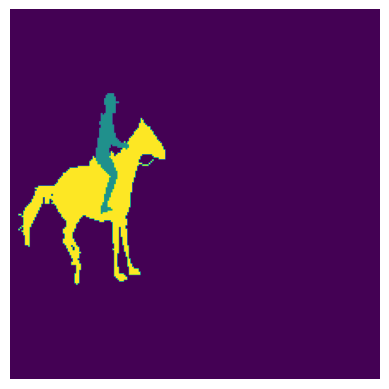

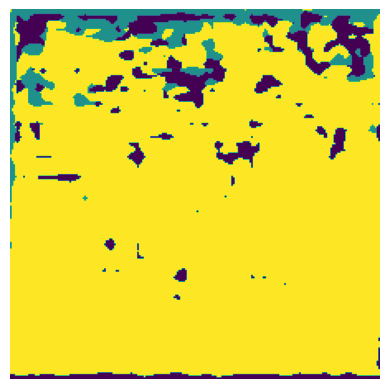

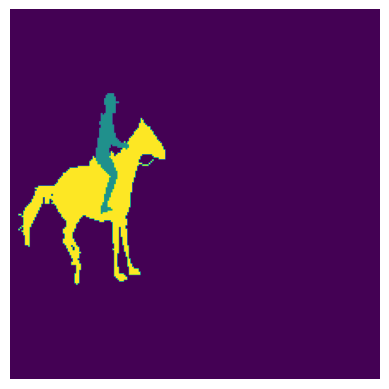

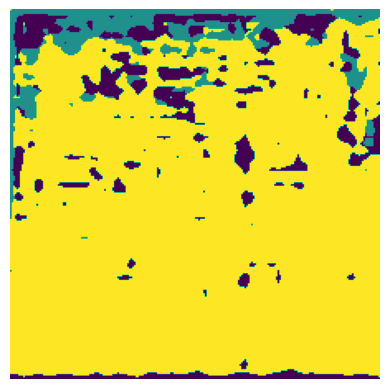

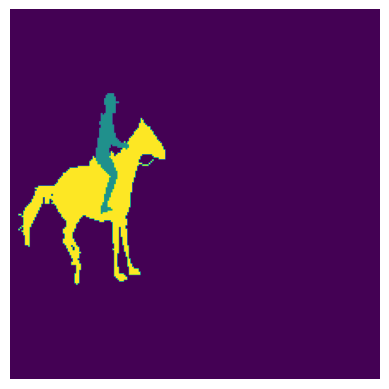

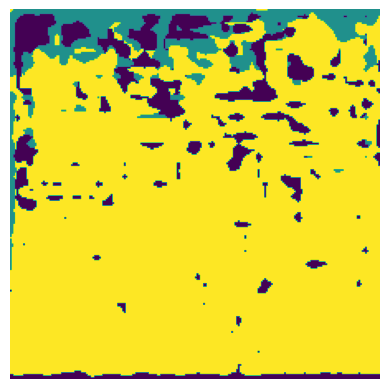

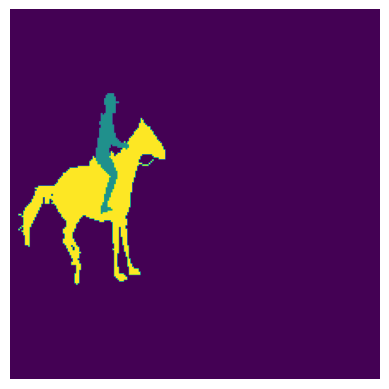

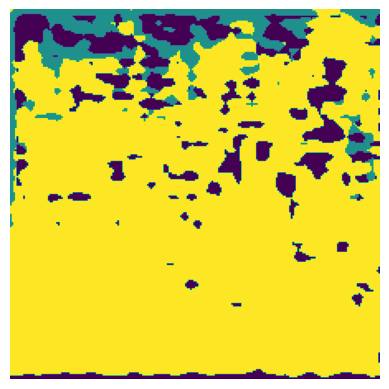

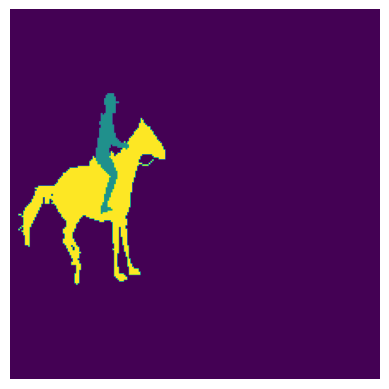

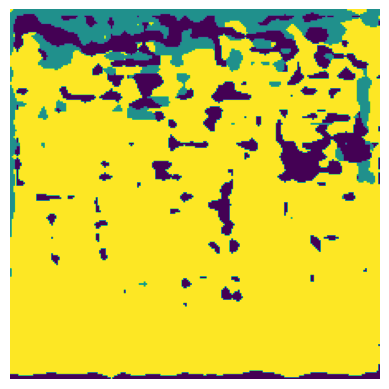

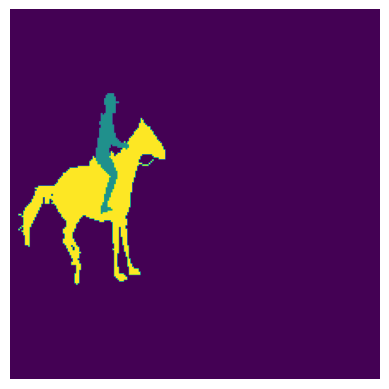

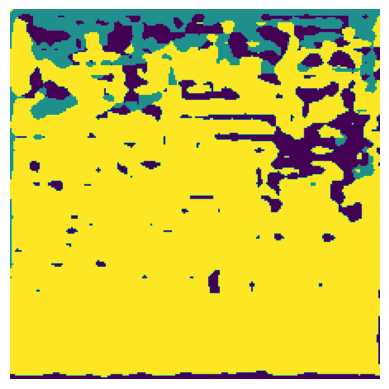

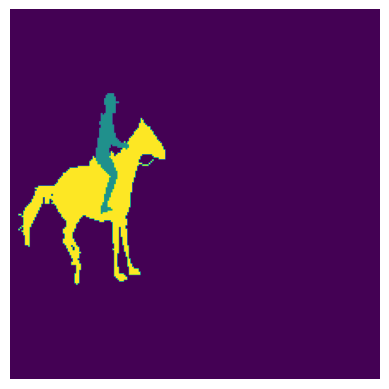

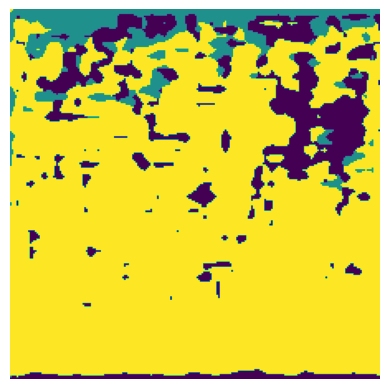

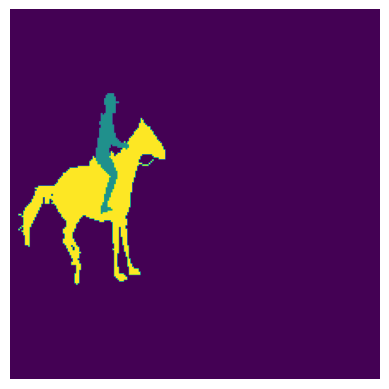

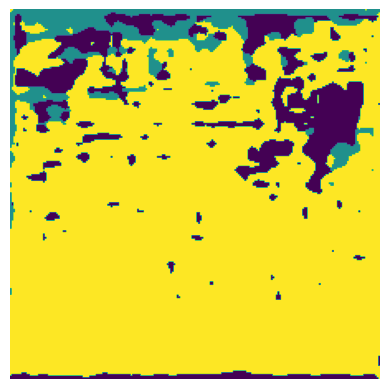

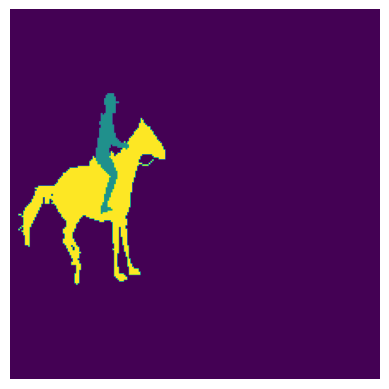

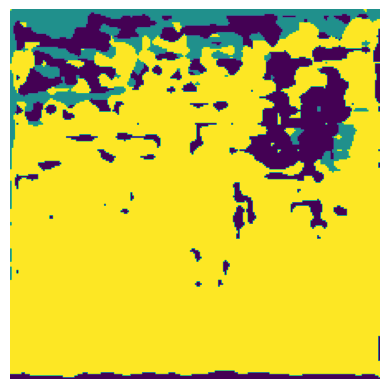

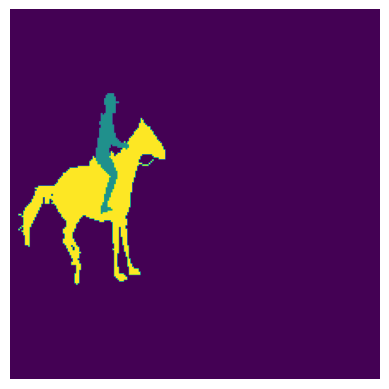

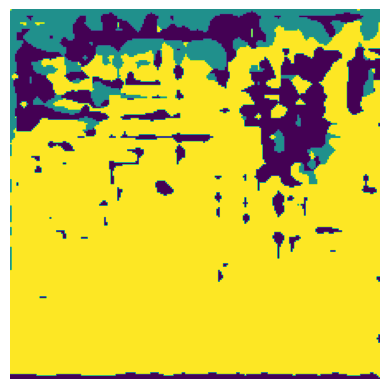

ICM done


In [35]:

image_root = train_image_root
mask_root = train_mask_root
target_list = val_list
# def eval(image_root, mask_root, target_list):
# global mask, osvos_mask, flo, imgs, gray_imgs, cnn_mask
for p in range(len(target_list)):
    
    if p != 15:
        continue
    image_path = os.path.join(image_root, target_list[p])
    mask_path = os.path.join(mask_root, target_list[p] + '/00000.png')
    osvos_path = os.path.join(rough_annotation_root, target_list[p])
    result_path = os.path.join(result_root, target_list[p])
    flow_path = os.path.join(train_flow_root, target_list[p])
    model_save_path = os.path.join(models_root, target_list[p] + '.pt')

    image_list = sorted(os.listdir(image_path))
    image_list = image_list[:10]
    mask = cv2.imread(mask_path)

    mask = np.expand_dims(mask, axis=0)
    mask = np.tile(mask, (len(image_list), 1, 1, 1))
    imgs = np.zeros_like(mask)
    osvos_mask = np.zeros_like(mask)
    mask, color_to_gray_map, gray_to_color_map = convert_to_gray_mask(mask)
    gray_imgs = np.zeros_like(mask)

    type_cnt = len(color_to_gray_map)
    print('type_cnt:', type_cnt)
    # TODO: type_cnt > 2

    for i in range(len(image_list)):
        osvos_mask[i] = cv2.imread(os.path.join(osvos_path, f"{i:05d}.png"))

    osvos_mask, _, _ = convert_to_gray_mask(osvos_mask)
    osvos_mask[0] = mask[0]

    resized_mask = np.zeros((mask.shape[0], Resize[1], Resize[0]))
    resized_osvos_mask = np.zeros((mask.shape[0], Resize[1], Resize[0]))

    for i in range(mask.shape[0]):
        resized_mask[i] = cv2.resize(mask[i], Resize, interpolation=cv2.INTER_NEAREST)
        resized_osvos_mask[i] = cv2.resize(osvos_mask[i], Resize, interpolation=cv2.INTER_NEAREST)

    mask = resized_mask
    osvos_mask = resized_osvos_mask
    flo = np.zeros_like(mask)
    flo = np.tile(np.expand_dims(flo, axis=-1), (1, 1, 1, 2))
    del resized_mask, resized_osvos_mask

    resized_imgs = np.zeros((mask.shape[0], Resize[1], Resize[0], 3), dtype=np.uint8)
    for i in range(len(image_list)):
        cv2.imread(os.path.join(image_path, f"{i:05d}.jpg"))
        imgs[i] = cv2.imread(os.path.join(image_path, f"{i:05d}.jpg"))
        imgs[i] = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB)

    print(imgs[i].shape)

    for i in range(len(image_list)):
        resized_imgs[i] = cv2.resize(imgs[i], Resize, interpolation=cv2.INTER_NEAREST)

    imgs = resized_imgs
    del resized_imgs
    gray_imgs = np.zeros((mask.shape[0], Resize[1], Resize[0]), dtype=np.uint8)

    for i in range(len(image_list)):
        gray_imgs[i] = cv2.cvtColor(imgs[i], cv2.COLOR_RGB2GRAY)

    for i in range(len(image_list) - 1):
        # flo[i] = cv2.calcOpticalFlowFarneback(gray_imgs[i], gray_imgs[i + 1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flo[i] = resize_flo(read_flo_file(os.path.join(flow_path, f"{i:06d}.flo"))) 
        
    flo = filter_unreliable_flow(flo)

    init()

    cnn_mask = mask.copy()
    model = MyResNet(len(color_to_gray_map)).to(device)
    model_save_path = os.path.join(model_save_path)
    model.eval()
    print('Precomputing positions from optical flow...')
    
    for _ in range(total_iter):
        
        diff_pixel = np.sum(mask != cnn_mask)        
        
        for _ in tqdm(range(ICM_iter)):
            tasks = [(t, x, y, k) for t in range(len(image_list)) for x in range(mask.shape[1]) for y in
                     range(mask.shape[2]) for k in range(type_cnt)]
            with Pool() as pool:
                e_results = np.array(list(pool.map(energy, tasks)))
            e_results = np.array(e_results).reshape((len(image_list), mask.shape[1], mask.shape[2], type_cnt))
            mask = np.argmin(e_results, axis=-1)
            
        cnn_eval()
    
    print('ICM done')
    
    # write
    if os.path.exists(result_path):
        shutil.rmtree(result_path)
    os.makedirs(result_path)
    
    resized_mask = np.zeros((mask.shape[0], OriginalSize[1], OriginalSize[0]))
    for i in range(len(image_list)):
        resized_mask[i] = cv2.resize(mask[i], OriginalSize, interpolation=cv2.INTER_NEAREST)
    
    for i in range(len(image_list)):
        result_i_path = result_path + f"/{i:05d}.png"
        cv2.imwrite(result_i_path, restore_color_mask(resized_mask[i], gray_to_color_map))
    
    del resized_mask
    
    break


In [36]:
# eval(train_image_root, train_mask_root, val_list)